# Dataset Restructuring for Modelling
This project performs
- downsampling of EMG data from 2048Hz to 512Hz
- upsampling of glove data from 256Hz to 512Hz

- visualizations of the lengths of each trial of the labelled dataset 

- windowing and feature extraction of all data, and formulation of the dataframe that can be used for model train/testing

In [1]:
# Imports
from pathlib import Path
import os
import pickle
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
from dataclasses import dataclass
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import resample, decimate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    ConfusionMatrixDisplay,
)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import resample, decimate
import os

"""
Down sample the EMG data and interpolate the glove data
- The EMG data is 2048Hz nxt where n=number of channels (134) and t is number of time points
- The glove data is 256Hz mxt where m=number of joint angles (18) and t is number of time points
"""

ROOT = Path.cwd()
PKL_ROOT = ROOT / 'pkl_dataset'
OUT_ROOT = ROOT / 'pkl_dataset_resampled'  # new output folder (non-destructive)
GLOVE_FS = 256
EMG_FS = 2048
DOWNSAMPLED_EMG_FS = 512
RESAMPLED_GLOVE_FS = DOWNSAMPLED_EMG_FS

#### 1: check data in one file to confirm data shape and available vars
dirs = [entry.name for entry in os.scandir(PKL_ROOT) if entry.is_dir()]

for dir in dirs:
    files = [x for x in os.listdir(PKL_ROOT / Path(dir)) if '.pkl' in x]
    for file in files:
        if 'calibration' in file:
            continue
        df = pd.read_pickle(PKL_ROOT / Path(dir) / Path(file))
        # upsample glove data
        t = np.linspace(0, df['glove'].shape[-1]/GLOVE_FS, df['glove'].shape[-1], endpoint=True)
        upsampled_glove_data = resample(df['glove'], num=int(RESAMPLED_GLOVE_FS/GLOVE_FS)*df['glove'].shape[-1], t=t, axis=1)[0]

        # downsample emg data
        downsampled_emg_data = decimate(df['emg'], q=int(EMG_FS/DOWNSAMPLED_EMG_FS), n=2, axis=1)

        df['emg'] = downsampled_emg_data
        df['glove'] = upsampled_glove_data

        out_dir = OUT_ROOT / dir        # join path with string
        out_dir.mkdir(parents=True, exist_ok=True)

        out_file = out_dir / file

        with out_file.open("wb") as f:
            pickle.dump(df, f, protocol=pickle.HIGHEST_PROTOCOL)


In [4]:
"""
Features (from SEED dataset)
"""

def MAV(data):
    """
    :param data: 2D array, channels x samples
    :return: MAV of the data
    """
    return np.mean(np.abs(data), axis=1).reshape((1, data.shape[0]))

def VAR(data):
    """
    Variance
    :param data: 2D array, channels x samples
    :return: Variance of the data
    """
    return np.var(data, axis=1).reshape((1, data.shape[0]))

def RMS(data):
    """
    Root mean square
    :param data: 2D array, channels x samples
    :return: RMS per channel
    """
    return np.sqrt(np.mean(data**2, axis=1)).reshape((1, data.shape[0]))

def zero_crossings(data):
    """
    Number of zero crossings from each channel
    :param data: 2D array, channels x samples
    :return: number of zero crossings for each channel
    """
    positive = data > 0
    return np.sum(np.bitwise_xor(positive[:, 1:], positive[:, :-1]), axis=1).reshape((1, data.shape[0]))

def avg_amplitude_change(data):
    """
    https://www.sciencedirect.com/science/article/pii/S0957417412001200
    :param data: 2D array, channels x samples
    :return: Average amplitude change (AAC) as defined in the reference above
    """
    return np.mean(np.abs(np.diff(data, axis=1)), axis=1).reshape((1, data.shape[0]))

"""Additional frequency domain features"""

def spectral_centroid(data):
    """
    Spectral Centroid
    :param data: 2D array, channels x samples
    :return: Spectral centroid per channel (FFT-bin based)
    """
    # Magnitude spectrum
    spectrum = np.abs(np.fft.rfft(data, axis=1))
    
    # Frequency bin indices
    freqs = np.arange(spectrum.shape[1])
    
    # Avoid division by zero
    denom = np.sum(spectrum, axis=1) + 1e-12
    
    centroid = np.sum(spectrum * freqs, axis=1) / denom
    return centroid.reshape((1, data.shape[0]))


def spectral_spread(data):
    """
    Spectral Spread
    :param data: 2D array, channels x samples
    :return: Spectral spread per channel (FFT-bin based)
    """
    # Magnitude spectrum
    spectrum = np.abs(np.fft.rfft(data, axis=1))
    
    # Frequency bin indices
    freqs = np.arange(spectrum.shape[1])
    
    # Avoid division by zero
    denom = np.sum(spectrum, axis=1) + 1e-12
    
    # Spectral centroid
    centroid = np.sum(spectrum * freqs, axis=1) / denom
    
    # Spectral spread (standard deviation around centroid)
    spread = np.sqrt(
        np.sum(spectrum * (freqs - centroid[:, None])**2, axis=1) / denom
    )
    
    return spread.reshape((1, data.shape[0]))

Before building our dataset, out of interest, we plot:
- the distribution of trial lengths
- the distribution of trial lengths by movement and speed
- the distribution of labelled regions
- the distribution of labelled regions by movement and speed

In [ ]:
import math
import copy
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import resample, decimate
import os
from collections import defaultdict
import numpy as np
from pathlib import Path

records = []

# file handling
ROOT = Path.cwd()
LABELS = ROOT / 'labels'
DATA = ROOT / 'pkl_dataset_resampled'

## Load labels data
labels = pd.read_csv(LABELS / 'labels.csv', index_col=False)
kill_list = pd.read_csv(LABELS / 'kill_list.csv', index_col=False)
kill_list = kill_list['file'].to_list()

FS = 512

## Load in dataset
dirs = [entry.name for entry in os.scandir(DATA) if entry.is_dir()]
for dir in dirs:
    files = [x for x in os.listdir(DATA / dir) if '.pkl' in x]
    for file in files:
        # load data file
        temp = pd.read_pickle(DATA / dir / file)

        # disc and thumbAdd data are ignored
        if temp['movement'] == 'disc' or temp['movement'] == 'thumbAdd' or temp['movement'] == 'middle' or temp['movement'] == 'index' or file in kill_list:
            continue

        # get labels
        file_labs = labels.loc[labels['file'] == file].to_dict(orient='records')
        try:
            file_labs = file_labs[0]
            start_time = file_labs['start']
            end_time = file_labs['end']
        except:
            print(f"Could not find valid labels for file {file}")
            continue

        if end_time < start_time:
            print(f"Start time was greater than end time for file {file}")
            continue

        movement = temp['movement'][0]
        speed = temp['speed'][0]

        # =========================
        # summary statistics
        # =========================
        trial_length = len(temp['emg'][0, :]) / FS
        label_length = end_time - start_time

        # one labeled region per file (start–end)
        num_labelled_regions = 1

        records.append({
            'file': file,
            'movement': movement,
            'speed': speed,
            'trial_length': trial_length,
            'labelled_region_length': label_length
        })

# =========================
# Create summary DataFrame
# =========================
df = pd.DataFrame(records)


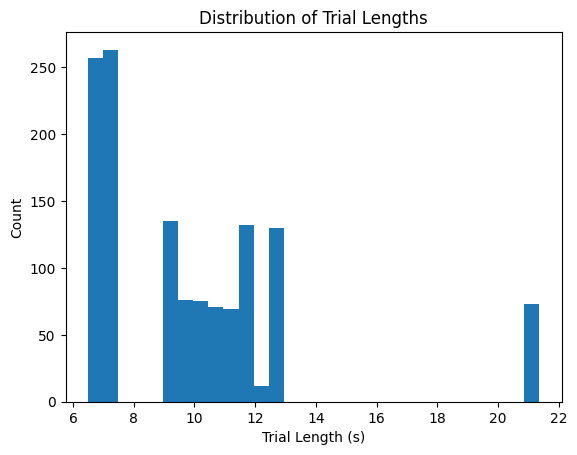

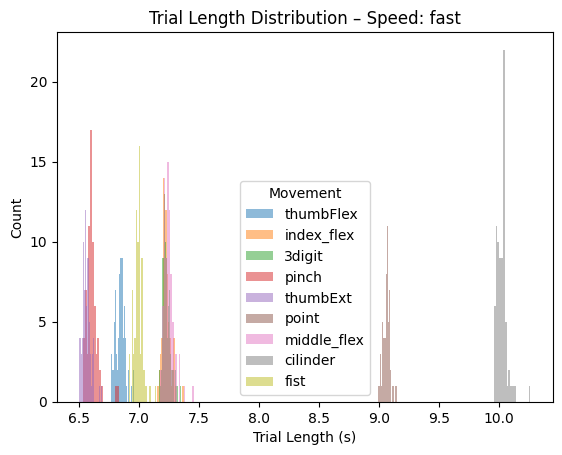

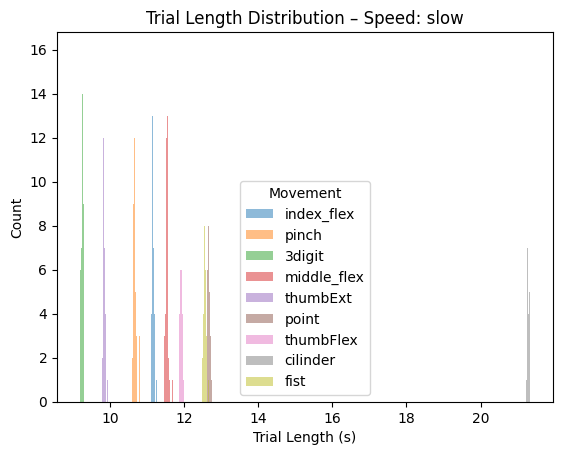

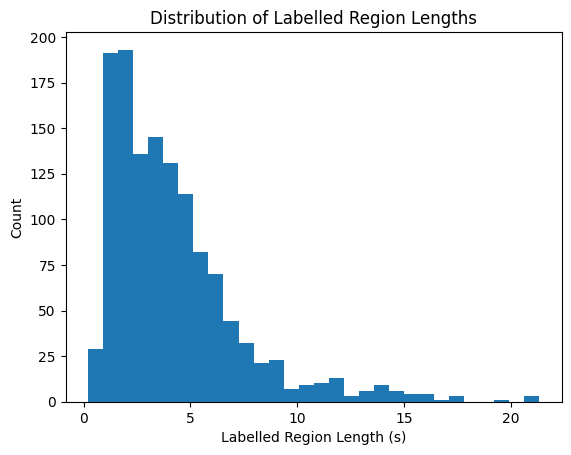

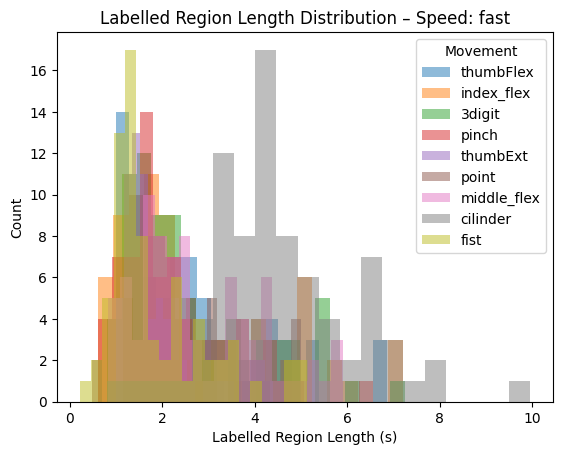

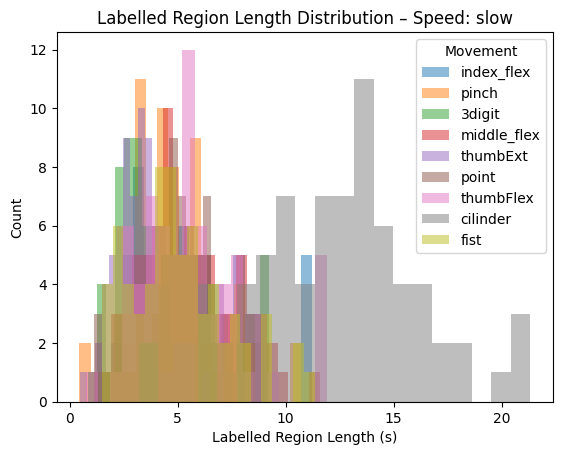

In [6]:
# =====================================================
# 1. Distribution of trial lengths (overall)
# =====================================================
plt.figure()
plt.hist(df['trial_length'], bins=30)
plt.xlabel('Trial Length (s)')
plt.ylabel('Count')
plt.title('Distribution of Trial Lengths')
plt.show()

# =====================================================
# 2. Distribution of trial lengths by movement & speed
# =====================================================

# fast plot
plt.figure()
subset = df[df['speed'] == 'fast']

for movement in subset['movement'].unique():
    data = subset[subset['movement'] == movement]['trial_length']
    plt.hist(data, bins=20, alpha=0.5, label=str(movement))

plt.xlabel('Trial Length (s)')
plt.ylabel('Count')
plt.title(f'Trial Length Distribution – Speed: fast')
plt.legend(title='Movement')
plt.show()

# slow plot
plt.figure()
subset = df[df['speed'] == 'slow']

for movement in subset['movement'].unique():
    data = subset[subset['movement'] == movement]['trial_length']
    plt.hist(data, bins=20, alpha=0.5, label=str(movement))

plt.xlabel('Trial Length (s)')
plt.ylabel('Count')
plt.title(f'Trial Length Distribution – Speed: slow')
plt.legend(title='Movement')
plt.show()

# =====================================================
# 3. Distribution of label lengths (overall)
# =====================================================
plt.figure()
plt.hist(df['labelled_region_length'], bins=30)
plt.xlabel('Labelled Region Length (s)')
plt.ylabel('Count')
plt.title('Distribution of Labelled Region Lengths')
plt.show()

# =====================================================
# 4. Distribution of trial lengths by movement & speed
# =====================================================
# fast plot
plt.figure()
subset = df[df['speed'] == 'fast']

for movement in subset['movement'].unique():
    data = subset[subset['movement'] == movement]['labelled_region_length']
    plt.hist(data, bins=20, alpha=0.5, label=str(movement))

plt.xlabel('Labelled Region Length (s)')
plt.ylabel('Count')
plt.title(f'Labelled Region Length Distribution – Speed: fast')
plt.legend(title='Movement')
plt.show()

# slow plot
plt.figure()
subset = df[df['speed'] == 'slow']

for movement in subset['movement'].unique():
    data = subset[subset['movement'] == movement]['labelled_region_length']
    plt.hist(data, bins=20, alpha=0.5, label=str(movement))

plt.xlabel('Labelled Region Length (s)')
plt.ylabel('Count')
plt.title(f'Labelled Region Length Distribution – Speed: slow')
plt.legend(title='Movement')
plt.show()

In [ ]:
import math
import copy
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import resample, decimate
import os

"""
Create a dataset for classification training/testing.
Each participant is stored in a separate file.
"""

def extract_windows(data, num_windows, window_size, window_step):
    windows = []
    for i in range(num_windows):
        start = int(i*window_step)
        end = int(start + window_size)
        win_data = data[:, start:end]
        windows.append(win_data)
    return windows

def num_windows(length, window_size, window_step):
    return int(math.floor((length - window_size) / window_step)) + 1

def extract_features_by_window(data, num_windows, window_size, window_step):
    """
    Splits data set into windows, extracts features for each window
    """

    feature_names = ['mav', 'var', 'rms', 'zcr', 'aac', 'sc', 'ss']

    windows = []
    for i in range(num_windows):
        start = int(i*window_step)
        end = int(start + window_size)
        win_data = data[:, start:end]

        feature_array = []
        feature_array.append(MAV(win_data))
        feature_array.append(VAR(win_data))
        feature_array.append(RMS(win_data))
        feature_array.append(zero_crossings(win_data))
        feature_array.append(avg_amplitude_change(win_data))
        feature_array.append(spectral_centroid(win_data))
        feature_array.append(spectral_spread(win_data))
        
        windows.append(feature_array)
    return windows, feature_names


# file handling
ROOT = Path.cwd()
LABELS = ROOT / 'labels'
DATA = ROOT / 'pkl_dataset_resampled'

# windowing
FS = 512
WINDOW_SIZE = int(0.2*FS)   # 200 ms windows
WINDOW_HOP = WINDOW_SIZE // 2 # 50% overlap (NOTE: WINDOW_HOP = WINDOW_SIZE - WINDOW_OVERLAP)

## Load labels data
labels = pd.read_csv(LABELS / 'labels.csv', index_col=False)
kill_list = pd.read_csv(LABELS / 'kill_list.csv', index_col=False)
kill_list = kill_list['file'].to_list()

## Create empty data frame for all data
dataset_columns = {'movement': [], 'speed': [], 'subject': [], 'session': [], 'trial': [], 'windows_raw': [], 'windows_feature': []}
df = pd.DataFrame(dataset_columns)

## Load in dataset
dirs = [entry.name for entry in os.scandir(DATA) if entry.is_dir()]
for dir in dirs:
    files = [x for x in os.listdir(DATA / dir) if '.pkl' in x]
    for file in files:
        # load data file
        temp = pd.read_pickle(DATA / dir / file)

        if temp['movement'] == 'disc' or temp['movement'] == 'thumbAdd' or temp['movement'] == 'middle' or temp['movement'] == 'index' or file in kill_list:
            continue

        temp_row = dataset_columns.copy()

        # get labels
        file_labs = labels.loc[labels['file'] == file].to_dict(orient='records') # note if this returns more than 1 row something is wrong
        # print(file_labs)
        try:
            file_labs = file_labs[0]
            try:
                start_sample = int(file_labs['start'] * FS)
                end_sample = int(file_labs['end'] * FS)
                # print(f"Start time: {start_sample / FS} | End time: {end_sample / FS}")
            except:
                raise ValueError(f'Could not access start')
        except:
                print(f"Could not find labels for file {file}")
                print(f"Movement: {temp['movement']} | Speed: {temp['speed']}")
        
        if end_sample < start_sample:
            print(f"Start time was less than end time for file {file}")
            print(f"Start time: {start_sample / FS} | End time: {end_sample / FS}")
            print("Continuing to next file")
            continue

        emg = temp['emg']
        emg = emg[:, start_sample:end_sample]

        # extract windows
        n_windows = num_windows(emg.shape[1], WINDOW_SIZE, WINDOW_HOP)
        windows = extract_windows(emg, n_windows, WINDOW_SIZE, WINDOW_HOP)
        feature_windows, feature_names = extract_features_by_window(emg, n_windows, WINDOW_SIZE, WINDOW_HOP)
        ## NOTE: we will need glove data later for regression, leave out for now

        ## append data to dataframe
        temp_row['windows_raw'] = windows
        temp_row['windows_feature'] = feature_windows
        temp_row['speed'] = str(temp['speed'][0])
        temp_row['subject'] = str(temp['subject'][0])
        temp_row['movement'] = str(temp['movement'][0])
        temp_row['session'] = int(temp['session'][0][0])
        temp_row['trial'] = int(str(file).split('.')[0].split('_')[-1])

        df_the_dict = pd.DataFrame([temp_row])
        df = pd.concat([df, df_the_dict], ignore_index=True)

Could not find labels for file detop_exp01_subj02_Sess3_02_02.pkl
Movement: ['index_flex'] | Speed: ['fast']
Could not find labels for file detop_exp01_subj03_Sess3_07_04.pkl
Movement: ['cilinder'] | Speed: ['fast']
Could not find labels for file detop_exp01_subj04_Sess2_11_02.pkl
Movement: ['pinch'] | Speed: ['slow']
Could not find labels for file detop_exp01_subj04_Sess1_03_05.pkl
Movement: ['point'] | Speed: ['slow']
Could not find labels for file detop_exp01_subj04_Sess1_05_06.pkl
Movement: ['3digit'] | Speed: ['fast']
Start time was less than end time for file detop_exp01_subj04_Sess1_05_01.pkl
Start time: 1.8515625 | End time: 0.6796875
Continuing to next file
Start time was less than end time for file detop_exp01_subj10_Sess1_13_04.pkl
Start time: 0.58984375 | End time: 0.0
Continuing to next file
Start time was less than end time for file detop_exp01_subj08_Sess2_08_05.pkl
Start time: 4.17578125 | End time: 0.296875
Continuing to next file
Could not find labels for file detop_e

In [8]:
## save dataset to pkl
df.to_pickle('dataset.pkl')